[View in Colaboratory](https://colab.research.google.com/github/ishachawla/Gun-Violence-/blob/master/BayesianApproach.ipynb)

# <center> A Bayesian approach to state-wise GunViolence </center>

***The main aim of this exercise is to take into considerations events that have happened in different states over the past years, use them as a reference to see how states compare to each other and using posterior distributions to generate some random values and try and determine how states fair again each other.***


**Libraries Used - Pymc3**
> PyMC is a python module that implements Bayesian statistical models and fitting algorithms, including Markov chain Monte Carlo. Its flexibility and extensibility make it applicable to a large suite of problems. Along with core sampling functionality, PyMC includes methods for summarizing output, plotting, goodness-of-fit and convergence diagnostics.

[*Pymc3 Documentation*]<a> https://pymc-devs.github.io/pymc/README.html</a>

*The first step here is to load the csv file from my machine and since I am working on Google Collab I had to upload the files to the cloud before I can start working on the data*

In [1]:
from google.colab import files
files.upload()

Saving stage3.csv to stage3.csv


In [0]:
import pandas as pd

In [3]:
files.os.listdir()

['datalab', '.config', '.cache', '.local', '.ipython', '.forever']

In [0]:
df=pd.read_csv("stage3.csv",parse_dates=['date'],infer_datetime_format=True)

In [4]:
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [0]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [0]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import decimal
%matplotlib inline

In [7]:
!pip install pymc3

    100% |████████████████████████████████| 1.3MB 5.7MB/s 
    100% |████████████████████████████████| 51kB 19.5MB/s 
    100% |████████████████████████████████| 276kB 11.1MB/s 
    100% |████████████████████████████████| 2.8MB 9.4MB/s 
  Running setup.py bdist_wheel for theano ... - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/87/1e/28/4a63195927452fb42d4ea6d1e5b3b1690409d66802cc9e1e6e
Successfully built theano


In [0]:
import itertools
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns

from IPython.display import Image
from sklearn import preprocessing

*Once I have my data the next step is to take into consideration  only the columns that we need, for the purpose of this we just need the states, the incidents that happened and how many people got injured or killed in that particular instance*

In [9]:
#A lot of these columns are not required for our analysis and a lot of them have more null values
#than we can fill so our first step will be eliminating these values.
print(list(df))
df=df.drop(['address','incident_url','source_url', 'incident_url_fields_missing', 'congressional_district','sources', 'state_house_district', 'state_senate_district','participant_relationship','participant_name','gun_stolen','latitude','longitude'],axis=1)
print("The total number of columns after dropping unnecessary columns are",df.shape[1])

['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured', 'incident_url', 'source_url', 'incident_url_fields_missing', 'congressional_district', 'gun_stolen', 'gun_type', 'incident_characteristics', 'latitude', 'location_description', 'longitude', 'n_guns_involved', 'notes', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_name', 'participant_relationship', 'participant_status', 'participant_type', 'sources', 'state_house_district', 'state_senate_district']
The total number of columns after dropping unnecessary columns are 16


In [10]:
#Filling the blanks to get to better results, for the number of guns involved use the median
df['n_guns_involved'][df['n_guns_involved'].isnull()]=df['n_guns_involved'].median()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
df.shape

(239677, 16)

In [0]:
x2=df[['state','n_killed','n_injured']]

*Before we start working with pymc3, we need to remember that states is not really numerical data, and pymc3 cannot work with categorical data, so we initalize Label Encoder to get a value assosciated with the States*

In [13]:
pre = preprocessing.LabelEncoder()
participants_idx = pre.fit_transform(x2['state'])
states = pre.classes_
total_states = len(states)
print("Labels:",states)
print("Total number of labels:",total_states)

Labels: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']
Total number of labels: 51


In [14]:
x2['total-incidents']=x2['n_injured']+x2['n_killed']
x2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,state,n_killed,n_injured,total-incidents
0,Pennsylvania,0,4,4
1,California,1,3,4
2,Ohio,1,3,4
3,Colorado,4,0,4
4,North Carolina,2,2,4


*Intializing a dictionary to save the values of every iteration so they can be easily accessed when we need them, this really helps us in further analysis, making it easier for us to iterarively see how our model was doing and how was it predicting the values*

In [278]:
x2[x2['state']=='Washington']['total-incidents'].values

array([5, 5, 4, ..., 0, 1, 0])

In [15]:
indiv_traces={}
for state in states:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = x2[x2['state']==state]['total-incidents'].values
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[state] = trace

logp = -6,378.4, ||grad|| = 0.0086828: 100%|██████████| 25/25 [00:00<00:00, 553.72it/s]  
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]
100%|██████████| 20500/20500 [00:45<00:00, 450.33it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The number of effective samples is smaller than 10% for some parameters.
logp = -1,277, ||grad|| = 121.43: 100%|█████

In [283]:
states[15]

'Iowa'

In [289]:
len(x2['total-incidents'][x2['state']=='Iowa'])

2517

In [308]:
len(df3[(df3['Alabama']>df3['Alaska'])==True])/len(df3)

0.442425

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6abd8cbba8>,
      dtype=object)

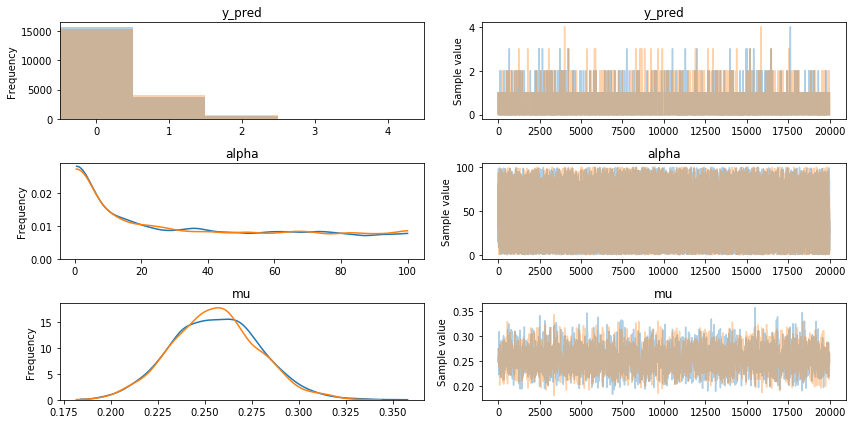

In [16]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ac61dfdd8>,
      dtype=object)

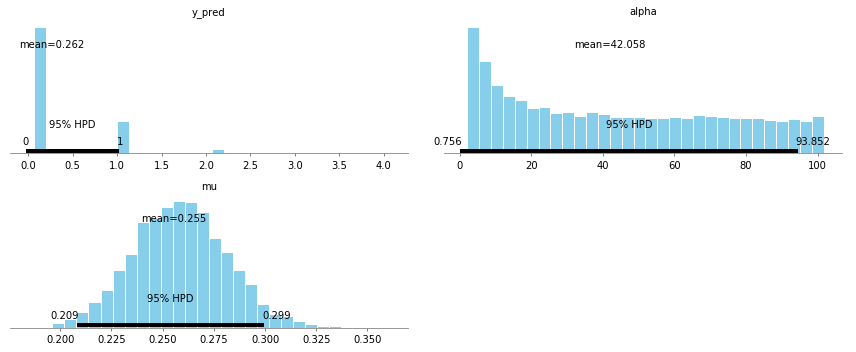

In [17]:
pm.plots.plot_posterior(trace)

**Now that we have our model, we need to check if it can capture the variance of the dataset and if we can use this model in the future as a forecasting model or rather as a WARNING MODEL, Gun-Violence is something that we should not be forecasting but because of the grave situation we are in right now, this is our best way to educate the people and the government and be vary of what will happen, if the situation does not change soon.**

*Once we have our model we use our dictionary to access the predicted values of each states and the next step will be plotting observed and predicted values and see if our model captures the original data well or if there is a need to change the paramters*

In [0]:
pred = pd.DataFrame( columns=states)
pred
for i in range(len(states)):
  pred[states[i]]=indiv_traces[states[i]].get_values('y_pred')

In [0]:
def calculate_state_incidents(state):
  for i in range(len(states)):
    if states[i]==state:
      return (indiv_traces[states[i]].get_values('y_pred'))

*Looking at the distribution plots for some states and check if our model and the actual values follow the same pattern*

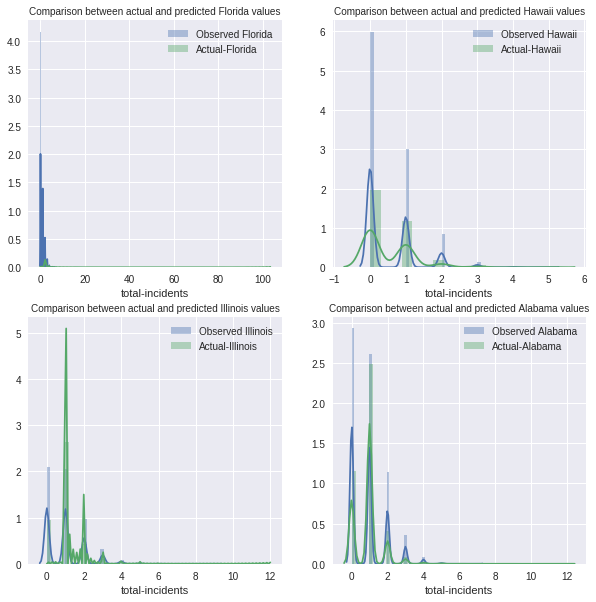

In [251]:
f,axes = plt.subplots(2, 2,figsize=(10, 10))
sb.set_style("darkgrid")
sb.set(rc={'figure.figsize':(8,5)})
sb.distplot(calculate_state_incidents('Florida'),label='Observed Florida',kde=True,ax=axes[0][0])
sb.distplot(x2['total-incidents'][x2['state']=='Florida'],kde=True,label='Actual-Florida',ax=axes[0][0])
axes[0][0].set_title("Comparison between actual and predicted Florida values",fontsize=10)
sb.distplot(calculate_state_incidents('Hawaii'),label='Observed Hawaii',kde=True,ax=axes[0][1])
sb.distplot(x2['total-incidents'][x2['state']=='Hawaii'],kde=True,label='Actual-Hawaii',ax=axes[0][1])
axes[0][1].set_title("Comparison between actual and predicted Hawaii values",fontsize=10)
sb.distplot(calculate_state_incidents('Illinois'),label='Observed Illinois',kde=True,ax=axes[1][0])
sb.distplot(x2['total-incidents'][x2['state']=='Illinois'],kde=True,label='Actual-Illinois',ax=axes[1][0])
axes[1][0].set_title("Comparison between actual and predicted Illinois values",fontsize=10)
sb.distplot(calculate_state_incidents('Alabama'),label='Observed Alabama',kde=True,ax=axes[1][1])
sb.distplot(x2['total-incidents'][x2['state']=='Alabama'],kde=True,label='Actual-Alabama',ax=axes[1][1])
axes[1][1].set_title("Comparison between actual and predicted Alabama values",fontsize=10)
axes[0][0].legend()
axes[0][1].legend()
axes[1][0].legend()
axes[1][1].legend()

In [0]:
total_incidents=0
for i in range(len(states)):
    total_incidents+=np.sum(calculate_state_incidents(states[i]))

In [319]:
len(pred[pred['Alaska']>pred['Alabama']])

7059

In [0]:
#Comparing two states to each other and finding out which state had more injuries per incident
def state_comparison(x,y):
  return len(pred[pred[x]>pred[y]])/len(pred)

In [322]:
print("Comparison between Alaska and Hawaii",state_comparison('Vermont','Wyoming')) #Comparing Wyoming and Vermont
print("Comparison between Hawaii and Texas",state_comparison('Hawaii','Texas'))#Comparing Hawaii and Texas

Comparison between Alaska and Hawaii 0.187525
Comparison between Hawaii and Texas 0.2166


*A low value signfies that two states have less incidents - looking at  Wyoming and Vermont we get a value close to 2 and if you look at Texas and Hawaii we get a high value because Texas has a really high number of gun violence incidents.*

> *Using this function we try and compute a matrix of all the states compared with each other and putting that value in a heatmap to get a more interactive insight about that particular state when compared to others*

In [323]:

df2_new = pd.DataFrame(index=states, columns=states, dtype=np.float)

# populate each cell in dataframe with persona_less_personb()
for a, b in itertools.permutations(states, 2):
    df2_new.ix[a, b] = state_comparison(a, b)
    
# populate the diagonal
for a in states:
    df2_new.ix[a, a] = 0.5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [324]:
df2_new.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Alabama,0.500000,0.442425,0.321850,0.371075,0.362000,0.400400,0.423100,0.400525,0.408075,0.376975,...,0.462750,0.355250,0.350875,0.392550,0.498800,0.351775,0.399575,0.397600,0.390700,0.502225
Alaska,0.176475,0.500000,0.169275,0.202600,0.193850,0.219350,0.237400,0.214950,0.227375,0.210325,...,0.267825,0.190200,0.187950,0.211275,0.291725,0.183675,0.218950,0.220550,0.219350,0.295600
Arizona,0.354275,0.471875,0.500000,0.391500,0.380000,0.427200,0.449575,0.421900,0.429625,0.397050,...,0.484475,0.377350,0.374700,0.414500,0.525425,0.372725,0.419650,0.420475,0.418225,0.525475
Arkansas,0.284000,0.383725,0.269050,0.500000,0.308725,0.341850,0.368375,0.339675,0.348000,0.321150,...,0.399175,0.302900,0.300175,0.338500,0.436175,0.297325,0.338825,0.343925,0.338400,0.437425
California,0.297475,0.404975,0.282050,0.330600,0.500000,0.361425,0.379600,0.358075,0.364975,0.337875,...,0.419550,0.318875,0.314300,0.351775,0.450725,0.308750,0.354000,0.359225,0.351200,0.456850


Text(0.5,1,'A probabilistic comparison between states ')

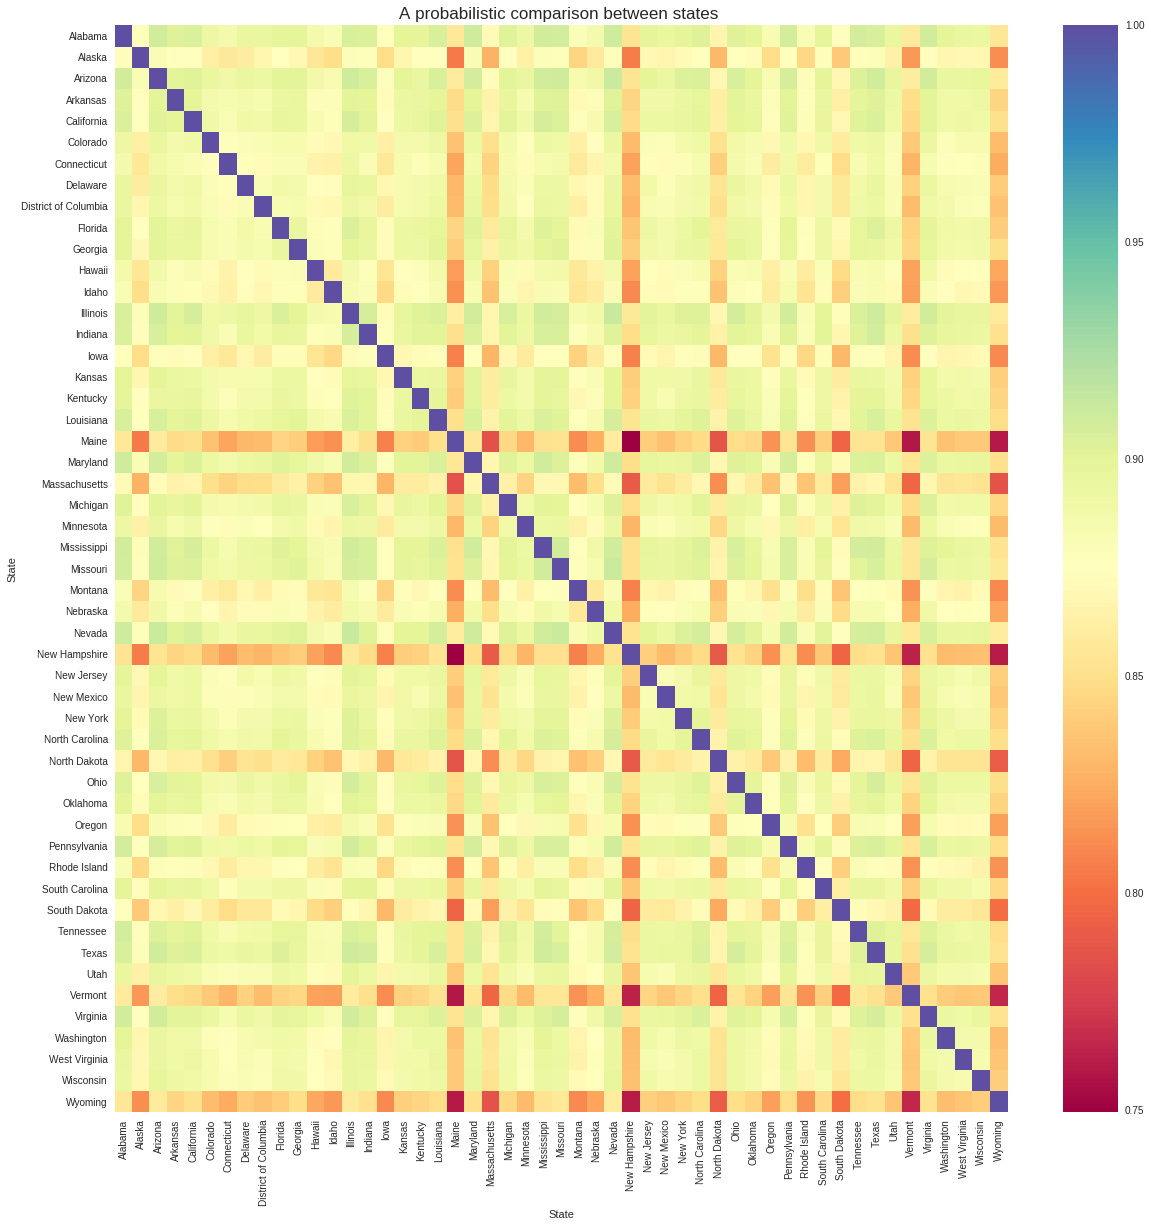

In [326]:
sb.set(rc={'figure.figsize':(20,20)})
sb.heatmap(df2_new.corr(),cmap="Spectral")
plt.xlabel("State")
plt.ylabel("State")
plt.title("A probabilistic comparison between states ",fontsize=17)

**REFERENCES:**


1.   <a > https://github.com/markdregan/Bayesian-Modelling-in-Python </a>
2.   <a>  https://pymc-devs.github.io/pymc/README.html </a>

